# Slate Off Policy Simulation - Open Bandit Dataset
---
This notebook demonstrates an example of conducting OPE of Bernoulli Thompson Sampling (BernoulliTS) as an evaluation policy. We use some OPE estimators and logged bandit data generated by running the Random policy (behavior policy) on the ZOZOTOWN platform. We also evaluate and compare the OPE performance (accuracy) of several estimators.

The example consists of the following four major steps:
- (1) Data Loading and Preprocessing
- (2) Replicating Production Policy and simulating another policy
- (3) Off-Policy Evaluation (OPE)
- (4) Evaluation of OPE

In [1]:
# needed when using Google Colab
# !pip install obp

In [61]:
# import open bandit pipeline (obp) packages
import os

import obp
from obp.dataset import OpenBanditDataset

from obp.policy import (
    BernoulliTS,
    Random
)



from obp.policy import (
    # ContextFree
    Random,
    EpsilonGreedy,
    BernoulliTS,

    # Contextual - Linear
    LinEpsilonGreedy,
    LinUCB,
    LinTS,

    # Contextual - Logistic
    LogisticEpsilonGreedy,
    LogisticUCB,
    LogisticTS,
)

from obp.policy import IPWLearner, Random

from obp.ope import (
    OffPolicyEvaluation,
    RegressionModel,
    InverseProbabilityWeighting,
    DirectMethod,
    DoublyRobust,
    SelfNormalizedDoublyRobust,
    DoublyRobustWithShrinkageTuning,
    SelfNormalizedInverseProbabilityWeighting,
    SwitchDoublyRobustTuning,
    InverseProbabilityWeightingTuning,
    DoublyRobustTuning,
    SubGaussianInverseProbabilityWeightingTuning,
    SubGaussianDoublyRobustTuning,
)


from obp.simulator import (
    run_bandit_simulation,
    calc_ground_truth_policy_value
)

# Other packages
# data analysis
import pandas as pd
import numpy as np

# plotting deps
from matplotlib import pyplot as plt
import seaborn as sns

# sklearn regressors
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import LogisticRegression


# path
from pathlib import Path

# system
import sys
import gc
import math


In [4]:
# obp version
print(obp.__version__)

0.5.5


In [5]:
# from dataclasses import dataclass
#
# @dataclass
# class OBDWithSlate(OpenBanditDataset):
#     context_set: str = "1"
#
#     def pre_process(self) -> None:
#
#         if self.context_set == "1":
#             super().pre_process()
#         elif self.context_set == "2":
#             self._pre_process_context_set_2()
#
#     def _pre_process_context_set_1(self) -> None:
#         """Create Context Set 1 (c.f., Section 5.2)"""
#
#         user_cols = self.data.columns.str.contains("user_feature")
#         self.context = pd.get_dummies(
#             self.data.loc[:, user_cols], drop_first=True
#         ).values
#
#     def _pre_process_context_set_2(self) -> None:
#         """Create Context Set 2 (c.f., Section 5.2)"""
#
#         super().pre_process()
#         affinity_cols = self.data.columns.str.contains("affinity")
#         Xaffinity = self.data.loc[:, affinity_cols].values
#         self.context = PCA(n_components=30).fit_transform(
#             np.c_[self.context, Xaffinity]
#         )


## (1) Data Loading and Preprocessing

`obp.dataset.OpenBanditDataset` is an easy-to-use data loader for Open Bandit Dataset. 

It takes behavior policy ('bts' or 'random') and campaign ('all', 'men', or 'women') as inputs and provides dataset preprocessing.

In [7]:
# complete dataset is kept here
data_path_complete = Path('/Users/mudev/Downloads/open_bandit_dataset/')

data_path_preprocessed_complete = Path('/Users/mudev/Downloads/open_bandit_dataset/preprocessed')

data_path_preprocessed_sample = Path('/Users/mudev/Downloads/open_bandit_dataset/preprocessed/sample')

In [8]:
# load and preprocess raw data in "All" campaign collected by the Random policy (behavior policy here)
# When `data_path` is not given, this class downloads the small-sized version of the Open Bandit Dataset.
dataset_random_all = OpenBanditDataset(behavior_policy='random', campaign='all', data_path=data_path_preprocessed_sample)

In [9]:
dataset_random_all_sample = OpenBanditDataset(behavior_policy='random', campaign='all')

INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.


In [100]:
# dataset_bts_all = OpenBanditDataset(behavior_policy='bts', campaign='all')

In [10]:
dataset_random_all.data.shape

(30006, 90)

In [11]:
dataset_random_all.data.head()

,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user-item_affinity_0,...,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79,slate_id
_c0,,,,,,,,,,,,,,,,,,,,,
9,2019-11-24T00:00:03.956Z,45,1,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,719dab53a7560218a9d1f96b25d6fa32,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,970662609927
10,2019-11-24T00:00:03.956Z,48,3,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,719dab53a7560218a9d1f96b25d6fa32,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,970662609927
11,2019-11-24T00:00:03.956Z,8,2,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,719dab53a7560218a9d1f96b25d6fa32,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,970662609927
120,2019-11-24T00:01:03.126Z,28,1,0,0.0125,cef3390ed299c09874189c387777674a,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,884763263977
121,2019-11-24T00:01:03.126Z,49,2,0,0.0125,cef3390ed299c09874189c387777674a,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,884763263977


In [12]:
dataset_random_all.item_context.head()

,item_id,item_feature_0,item_feature_1,item_feature_2,item_feature_3
0,0,-0.499172,d1e00cff339048c08ea666193d5033a3,49c9e5b248ae216179f56f01dc2af6b6,57bed6721fd0a0f839271cdf0e9fb2c1
1,1,-0.543775,d74a92caf4244a36013cd3c0d63dd295,49c9e5b248ae216179f56f01dc2af6b6,57bed6721fd0a0f839271cdf0e9fb2c1
2,2,0.972752,d74a92caf4244a36013cd3c0d63dd295,54426f203dec4609025bdcd3f70e1043,ff8b1f6688f83613aecd3fbc881bafb0
3,3,-0.521473,e3f540fa6d7911cd4ec38f8c3da11e67,1f692a394cf4cff118a1de54b5531e89,ad64ce82bf623357a97a1164f463a5da
4,4,1.909430,9b6d0728ea28dd8aa485eb824ce58f05,f4ae697a3823f829e791beef466f848b,ff8b1f6688f83613aecd3fbc881bafb0


### Dataset Understanding



### Properties

In [11]:
# name of the dataset is 'obd' (open bandit dataset)
dataset_random_all.dataset_name

'obd'

In [12]:
# Size of the logged bandit data
# small sample example data has 10,000 samples (or rounds)
dataset_random_all.n_rounds

30006

In [13]:
# number of actions
# name of the dataset is 'obd' (open bandit dataset)
dataset_random_all.n_actions

80

In [ ]:
# Dimensions of context vectors
# one-hot encoded matrix of user-context columns
# default context (feature) engineering creates context vector with 20 dimensions
dataset_random_all.dim_context

In [17]:
# ZOZOTOWN recommendation interface has three positions
# left, right and center
# (please see https://github.com/st-tech/zr-obp/blob/master/images/recommended_fashion_items.png)
dataset_random_all.len_list

3

### obtain_batch_bandit_feedback

the logged bandit dataset is collected by the behavior policy as follows.

$ \mathcal{D}_b := \{(x_i,a_i,r_i)\}$  where $(x,a,r) \sim p(x)\pi_b(a | x)p(r | x,a) $

In [157]:
# obtain logged bandit feedback generated by behavior policy
bandit_feedback_random_all = dataset_random_all.obtain_batch_bandit_feedback()

bandit_feedback_random_all_sample = dataset_random_all_sample.obtain_batch_bandit_feedback()

# `bandit_feedback` is a dictionary storing logged bandit feedback
type(bandit_feedback_random_all), bandit_feedback_random_all.keys()

(dict,
 dict_keys(['n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context']))

In [159]:
bandit_feedback_random_all

{'n_rounds': 30006,
 'n_actions': 80,
 'action': array([45, 48,  8, ..., 38, 40, 57]),
 'position': array([0, 2, 1, ..., 2, 1, 0]),
 'reward': array([0, 0, 0, ..., 0, 0, 0]),
 'pscore': array([0.0125, 0.0125, 0.0125, ..., 0.0125, 0.0125, 0.0125]),
 'context': array([[0, 1, 0, ..., 1, 0, 0],
        [0, 1, 0, ..., 1, 0, 0],
        [0, 1, 0, ..., 1, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 1],
        [0, 1, 0, ..., 0, 0, 1],
        [0, 1, 0, ..., 0, 0, 1]], dtype=uint8),
 'action_context': array([[ 9.00000000e+00,  6.00000000e+00,  1.00000000e+00,
         -4.99171626e-01],
        [ 1.00000000e+01,  6.00000000e+00,  1.00000000e+00,
         -5.43775368e-01],
        [ 1.00000000e+01,  8.00000000e+00,  6.00000000e+00,
          9.72751855e-01],
        [ 1.10000000e+01,  1.00000000e+00,  3.00000000e+00,
         -5.21473497e-01],
        [ 3.00000000e+00,  1.90000000e+01,  6.00000000e+00,
          1.90943043e+00],
        [ 1.10000000e+01,  6.00000000e+00,  1.00000000e+00,
  

#### Add Slate ID

In [17]:
bandit_feedback_random_all['slate_id'] = np.array(dataset_random_all.data.slate_id)

In [18]:
bandit_feedback_random_all

{'n_rounds': 30006,
 'n_actions': 80,
 'action': array([45, 48,  8, ..., 38, 40, 57]),
 'position': array([0, 2, 1, ..., 2, 1, 0]),
 'reward': array([0, 0, 0, ..., 0, 0, 0]),
 'pscore': array([0.0125, 0.0125, 0.0125, ..., 0.0125, 0.0125, 0.0125]),
 'context': array([[0, 1, 0, ..., 1, 0, 0],
        [0, 1, 0, ..., 1, 0, 0],
        [0, 1, 0, ..., 1, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 1],
        [0, 1, 0, ..., 0, 0, 1],
        [0, 1, 0, ..., 0, 0, 1]], dtype=uint8),
 'action_context': array([[ 9.00000000e+00,  6.00000000e+00,  1.00000000e+00,
         -4.99171626e-01],
        [ 1.00000000e+01,  6.00000000e+00,  1.00000000e+00,
         -5.43775368e-01],
        [ 1.00000000e+01,  8.00000000e+00,  6.00000000e+00,
          9.72751855e-01],
        [ 1.10000000e+01,  1.00000000e+00,  3.00000000e+00,
         -5.21473497e-01],
        [ 3.00000000e+00,  1.90000000e+01,  6.00000000e+00,
          1.90943043e+00],
        [ 1.10000000e+01,  6.00000000e+00,  1.00000000e+00,
  

## (2) Replicating Production Policy

After preparing the dataset, we now replicate the BernoulliTS policy implemented on the ZOZOTOWN recommendation interface during the data collection period.

Here, we use `obp.policy.BernoulliTS` as an evaluation policy. 
By activating its `is_zozotown_prior` argument, we can replicate (the policy parameters of) BernoulliTS used in the ZOZOTOWN production.

(When `is_zozotown_prior=False`, non-informative prior distribution is used.)

**Note: BernoulliTs is not a contextual bandit (context free),
so it don't require context (such as User-Context, Action-Context, User-Action-Affinity)**

In [21]:
# define BernoulliTS as an evaluation policy
evaluation_policy_berts_prior_wrights = BernoulliTS(
    n_actions=dataset_random_all.n_actions,
    len_list=dataset_random_all.len_list,
    is_zozotown_prior=True, # replicate the BernoulliTS policy in the ZOZOTOWN production
    campaign="all",
    random_state=12345,
)

evaluation_policy_berts_prior_wrights

BernoulliTS(n_actions=80, len_list=3, batch_size=1, random_state=12345, alpha=[47.0, 8.0, 62.0, 142.0, 3.0, 14.0, 7.0, 857.0, 12.0, 15.0, 6.0, 100.0, 48.0, 23.0, 71.0, 61.0, 13.0, 16.0, 518.0, 30.0, 7.0, 4.0, 23.0, 8.0, 10.0, 11.0, 11.0, 18.0, 121.0, 11.0, 11.0, 10.0, 14.0, 9.0, 204.0, 58.0, 3.0, 19.0, 42.0, 1013.0, 2.0, 328.0, 15.0, 31.0, 14.0, 138.0, 45.0, 55.0, 23.0, 38.0, 10.0, 401.0, 52.0, 6.0, 3.0, 6.0, 5.0, 32.0, 35.0, 133.0, 52.0, 820.0, 43.0, 195.0, 8.0, 42.0, 40.0, 4.0, 32.0, 30.0, 9.0, 22.0, 6.0, 23.0, 5.0, 54.0, 8.0, 22.0, 65.0, 246.0], beta=[12198.0, 3566.0, 15993.0, 35522.0, 2367.0, 4609.0, 3171.0, 181745.0, 4372.0, 4951.0, 3100.0, 24665.0, 13210.0, 7061.0, 18061.0, 17449.0, 5644.0, 6787.0, 111326.0, 8776.0, 3334.0, 2271.0, 7389.0, 2659.0, 3665.0, 4724.0, 3561.0, 5085.0, 27407.0, 4601.0, 4756.0, 4120.0, 4736.0, 3788.0, 45292.0, 14719.0, 2189.0, 5589.0, 11995.0, 222255.0, 2308.0, 70034.0, 4801.0, 8274.0, 5421.0, 31912.0, 12213.0, 13576.0, 6230.0, 10382.0, 4141.0, 85731.0, 

In [22]:
# compute the `action choice probabilities` of the `evaluation policy` via `Monte Carlo simulation`
# representing the distribution over actions by the evaluation policy
# Probability estimates of each arm being the best one for each sample, action, and position

action_dist_berts_prior_wrights = evaluation_policy_berts_prior_wrights.compute_batch_action_dist(
    n_sim=100000, n_rounds=bandit_feedback_random_all["n_rounds"],
)

In [23]:
# `action_dist` is an array of shape (n_rounds, n_actions, len_list)
# Probability estimates of each arm being the best one for each sample, action, and position
print(action_dist_berts_prior_wrights.shape, "\n")

action_dist_berts_prior_wrights[6].T

(30006, 80, 3) 



array([[1.0780e-02, 1.6700e-03, 5.8000e-03, 4.6000e-04, 3.5000e-04,
        8.4200e-03, 2.5500e-03, 7.6600e-03, 4.2100e-03, 7.0200e-03,
        1.0000e-03, 3.5400e-03, 2.8600e-03, 4.8900e-03, 5.0100e-03,
        3.5000e-04, 2.3000e-04, 8.0000e-05, 8.9400e-03, 4.3300e-03,
        1.3100e-03, 2.0500e-03, 2.3600e-03, 2.7850e-02, 6.4800e-03,
        5.0000e-04, 2.0470e-02, 2.8200e-02, 2.4280e-02, 8.5000e-04,
        5.4000e-04, 1.7600e-03, 6.4400e-03, 1.9400e-03, 1.5900e-02,
        9.1000e-03, 6.6000e-04, 1.5590e-02, 1.9600e-03, 3.5000e-04,
        2.0000e-05, 2.7180e-02, 1.0780e-02, 1.8250e-02, 8.7000e-04,
        1.0930e-02, 4.8400e-03, 1.9330e-02, 2.9570e-02, 7.8900e-03,
        1.5700e-03, 1.8780e-02, 2.3580e-02, 4.2600e-03, 5.2000e-04,
        5.1800e-03, 7.8000e-04, 2.3200e-03, 1.1410e-02, 9.0790e-02,
        6.0970e-02, 1.9848e-01, 2.6200e-03, 7.4190e-02, 6.3600e-03,
        4.2300e-03, 7.8900e-03, 1.4000e-04, 9.5200e-03, 6.0400e-03,
        1.0400e-03, 8.6700e-03, 7.4000e-04, 9.52

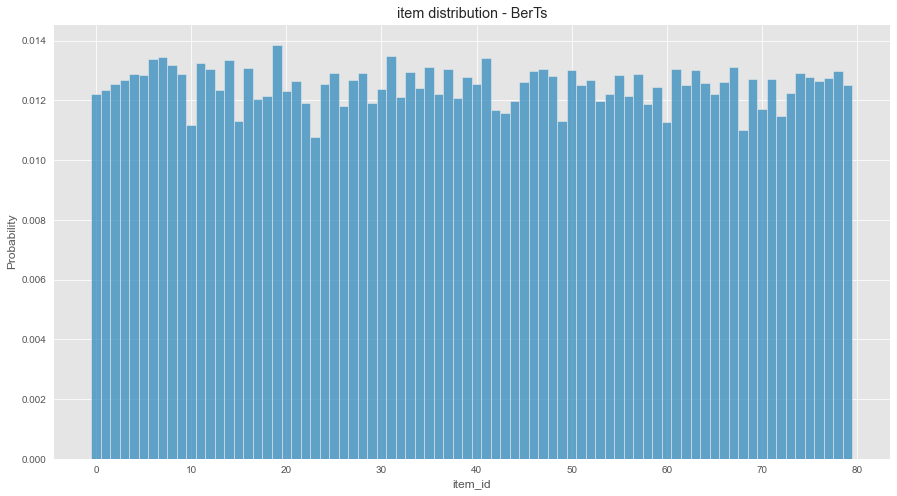

In [223]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
plt.title("item distribution - BerTs")
sns.histplot(x=dataset_random_all.data.item_id, discrete=True, stat='probability')
plt.show()

In [25]:
action_dist_berts_prior_wrights.shape

(30006, 80, 3)

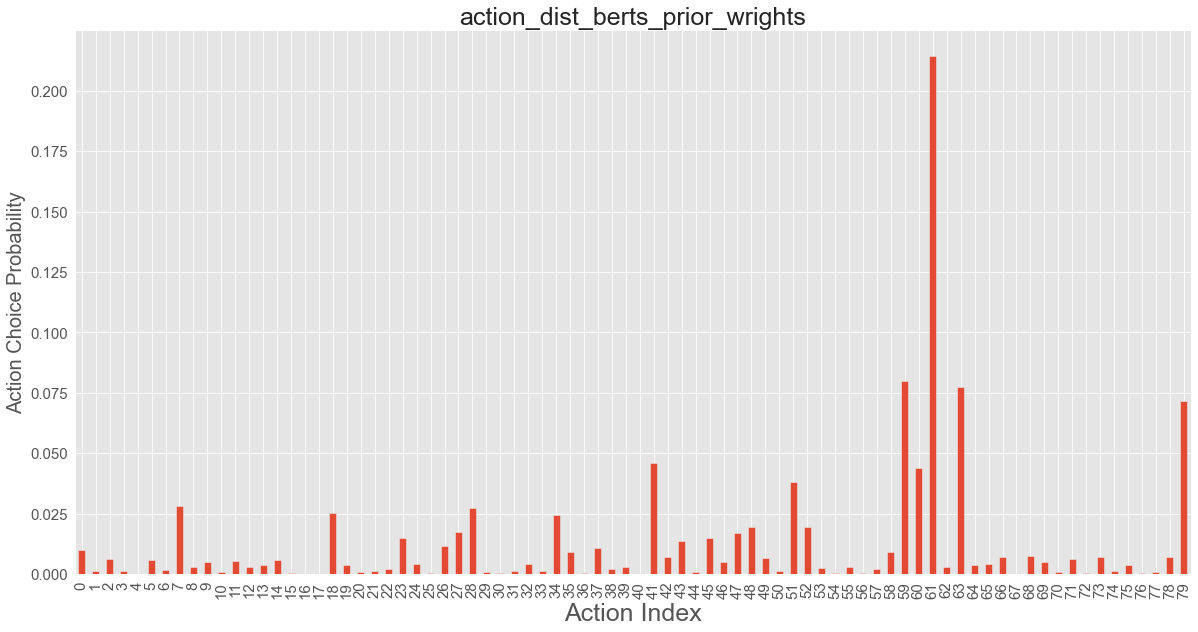

In [41]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(25, 15))

pd.Series(action_dist_berts_prior_wrights.mean(axis=0).mean(axis=1)).plot(kind='bar', figsize=(20,10), ax=ax)

plt.title(f"action_dist_berts_prior_wrights", fontsize=25)

plt.xlabel("Action Index", fontsize=25)

plt.ylabel(
    f"Action Choice Probability", fontsize=20
)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.savefig(str(Path.cwd() / "action_dist_berts_prior_wrights.png"))

### Testing BerTS without Prior weights (non production)

In [107]:
# define BernoulliTS as an evaluation policy
evaluation_policy_berts_simulation = BernoulliTS(
    n_actions=dataset_random_all.n_actions,
    len_list=dataset_random_all.len_list,
    batch_size=1,
    random_state=12345,
)

evaluation_policy_berts_simulation

BernoulliTS(n_actions=80, len_list=3, batch_size=1, random_state=12345, alpha=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), beta=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), is_zozotown_prior=False, campaign=None, policy_name='bts')

In [108]:
action_dist_berts_simulation = run_bandit_simulation(
    bandit_feedback=bandit_feedback_random_all,
    policy=evaluation_policy_berts_simulation
)

100%|██████████| 30006/30006 [00:01<00:00, 18170.92it/s]


In [220]:
pd.DataFrame(action_dist_berts_simulation.mean(axis=0))

,0,1,2
0,0.016863,0.016163,0.014630
1,0.013031,0.012031,0.011964
2,0.020163,0.017097,0.016363
3,0.012431,0.014730,0.013697
4,0.011464,0.012997,0.012398
...,...,...,...
75,0.017097,0.017197,0.016163
76,0.015430,0.016097,0.014564
77,0.006499,0.008598,0.009898
78,0.010131,0.011264,0.010331


In [222]:
"hgs hgsh hgh".replace(' ', '_')

'hgs_hgsh_hgh'

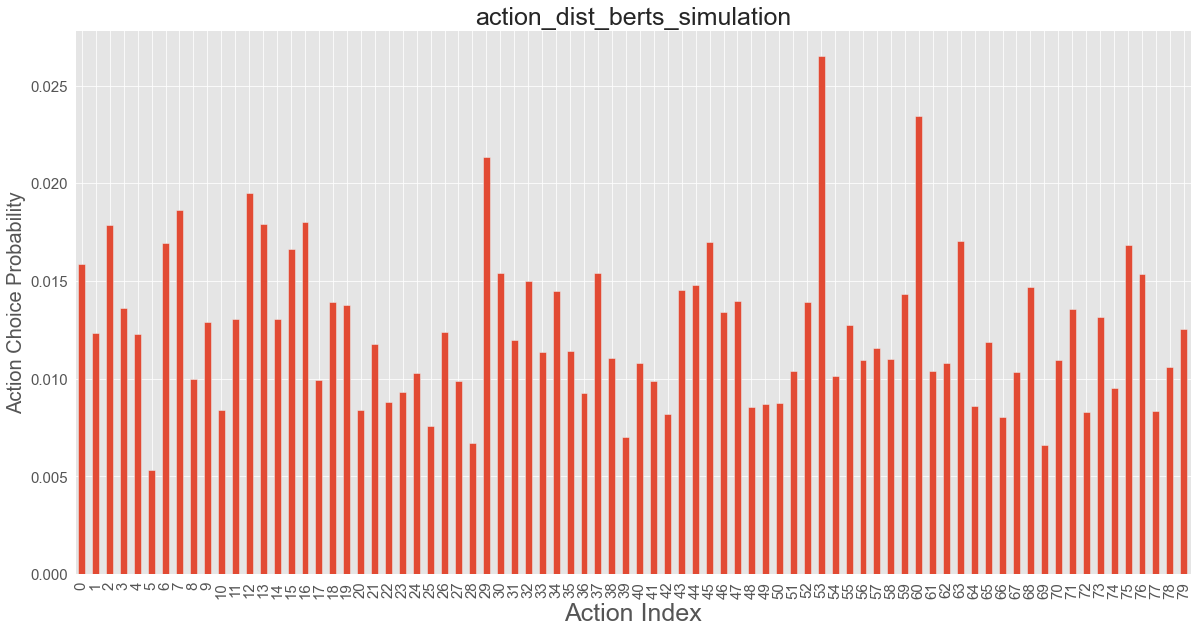

In [221]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(25, 15))

pd.Series(action_dist_berts_simulation.mean(axis=0).mean(axis=1)).plot(kind='bar', figsize=(20,10), ax=ax)

plt.title(f"action_dist_berts_simulation", fontsize=25)

plt.xlabel("Action Index", fontsize=25)

plt.ylabel(
    f"Action Choice Probability", fontsize=20
)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.savefig(str(Path.cwd() / "action_dist_berts_simulation.png"))

### Testing EpsilonGreedy without Prior weights (non production)

In [110]:
# define BernoulliTS as an evaluation policy
evaluation_policy_eg_simulation = EpsilonGreedy(
    n_actions=dataset_random_all.n_actions,
    len_list=dataset_random_all.len_list,
    batch_size=1,
    epsilon=0.1,
    random_state=12345,
)

evaluation_policy_eg_simulation

EpsilonGreedy(n_actions=80, len_list=3, batch_size=1, random_state=12345, epsilon=0.1)

In [111]:
action_dist_eg_simulation = run_bandit_simulation(
    bandit_feedback=bandit_feedback_random_all,
    policy=evaluation_policy_eg_simulation
)

100%|██████████| 30006/30006 [00:00<00:00, 35814.98it/s]


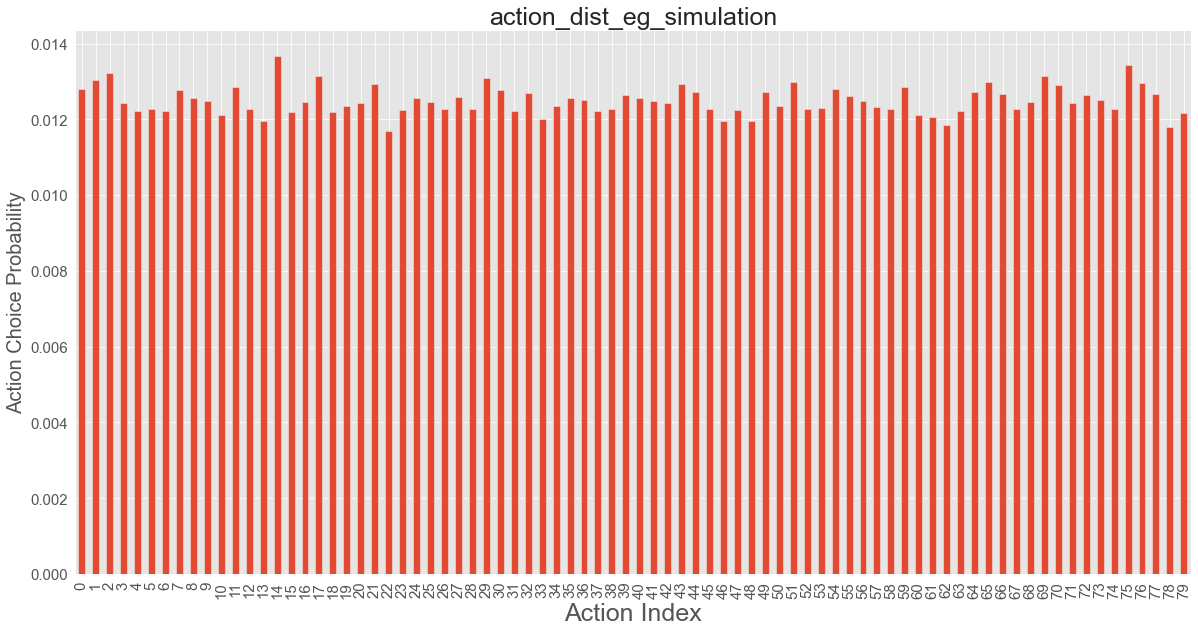

In [112]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(25, 15))

pd.Series(action_dist_eg_simulation.mean(axis=0).mean(axis=1)).plot(kind='bar', figsize=(20,10), ax=ax)

plt.title(f"action_dist_eg_simulation", fontsize=25)

plt.xlabel("Action Index", fontsize=25)

plt.ylabel(
    f"Action Choice Probability", fontsize=20
)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.savefig(str(Path.cwd() / "action_dist_eg_simulation.png"))

### Testing Random without Prior weights (non production)

In [182]:
# define BernoulliTS as an evaluation policy
evaluation_policy_random_simulation = Random(
    n_actions=dataset_random_all.n_actions,
    len_list=dataset_random_all.len_list,
    batch_size=1,
    random_state=12345,
    policy_name="random"
)

evaluation_policy_random_simulation

Random(n_actions=80, len_list=3, batch_size=1, random_state=12345, epsilon=1.0, policy_name='egreedy_1.0')

In [114]:
action_dist_random_simulation = run_bandit_simulation(
    bandit_feedback=bandit_feedback_random_all,
    policy=evaluation_policy_random_simulation
)

100%|██████████| 30006/30006 [00:00<00:00, 41171.62it/s]


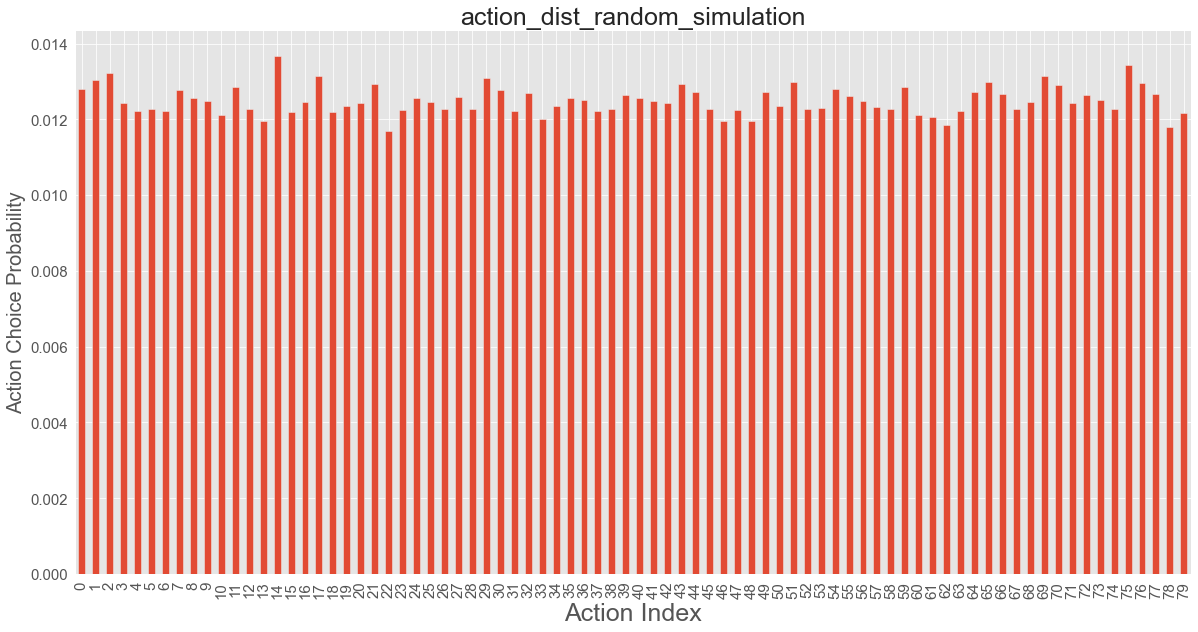

In [115]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(25, 15))

pd.Series(action_dist_random_simulation.mean(axis=0).mean(axis=1)).plot(kind='bar', figsize=(20,10), ax=ax)

plt.title(f"action_dist_random_simulation", fontsize=25)

plt.xlabel("Action Index", fontsize=25)

plt.ylabel(
    f"Action Choice Probability", fontsize=20
)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.savefig(str(Path.cwd() / "action_dist_random_simulation.png"))

### Testing LinTS - contextual (non production)

In [82]:
# define BernoulliTS as an evaluation policy
evaluation_policy_lints_simulation = LinTS(
    dim=dataset_random_all.dim_context,
    n_actions=dataset_random_all.n_actions,
    len_list=dataset_random_all.len_list,
    batch_size=100,
    random_state=12345,
)

evaluation_policy_lints_simulation

LinTS(dim=24, n_actions=80, len_list=3, batch_size=100, random_state=12345)

In [83]:
%%time

action_dist_lints_simulation = run_bandit_simulation(
    bandit_feedback=bandit_feedback_random_all,
    policy=evaluation_policy_lints_simulation,
)

100%|██████████| 30006/30006 [07:04<00:00, 70.63it/s]


CPU times: user 6min 21s, sys: 44 s, total: 7min 5s
Wall time: 7min 4s


In [84]:
action_dist_lints_simulation[0].T

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

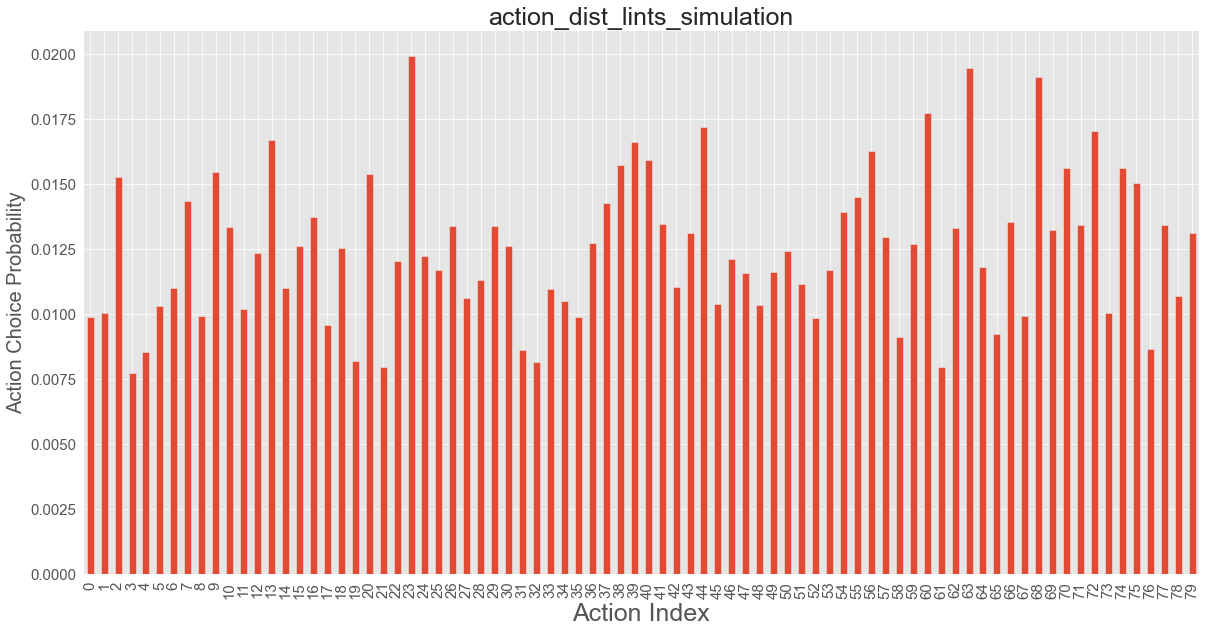

In [212]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(25, 15))


pd.Series(action_dist_lints_simulation.mean(axis=0).mean(axis=1)).plot(kind='bar', figsize=(20,10), ax=ax)

plt.title(f"action_dist_lints_simulation", fontsize=25)

plt.xlabel("Action Index", fontsize=25)

plt.ylabel(
    f"Action Choice Probability", fontsize=20
)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.savefig(str(Path.cwd() / "action_dist_lints_simulation.png"))

### Testing LinUCB - contextual (non production)

In [68]:
# define BernoulliTS as an evaluation policy
evaluation_policy_linucb_simulation = LinUCB(
    dim=dataset_random_all.dim_context,
    n_actions=dataset_random_all.n_actions,
    len_list=dataset_random_all.len_list,
    batch_size=100,
    random_state=12345,
    epsilon=0.1
)

evaluation_policy_linucb_simulation

LinUCB(dim=24, n_actions=80, len_list=3, batch_size=100, random_state=12345, epsilon=0.1)

In [69]:
%%time

action_dist_liucb_simulation = run_bandit_simulation(
    bandit_feedback=bandit_feedback_random_all,
    policy=evaluation_policy_linucb_simulation,
)

100%|██████████| 30006/30006 [00:21<00:00, 1393.45it/s]

CPU times: user 21 s, sys: 812 ms, total: 21.9 s
Wall time: 21.6 s


In [70]:
action_dist_liucb_simulation[0].T

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

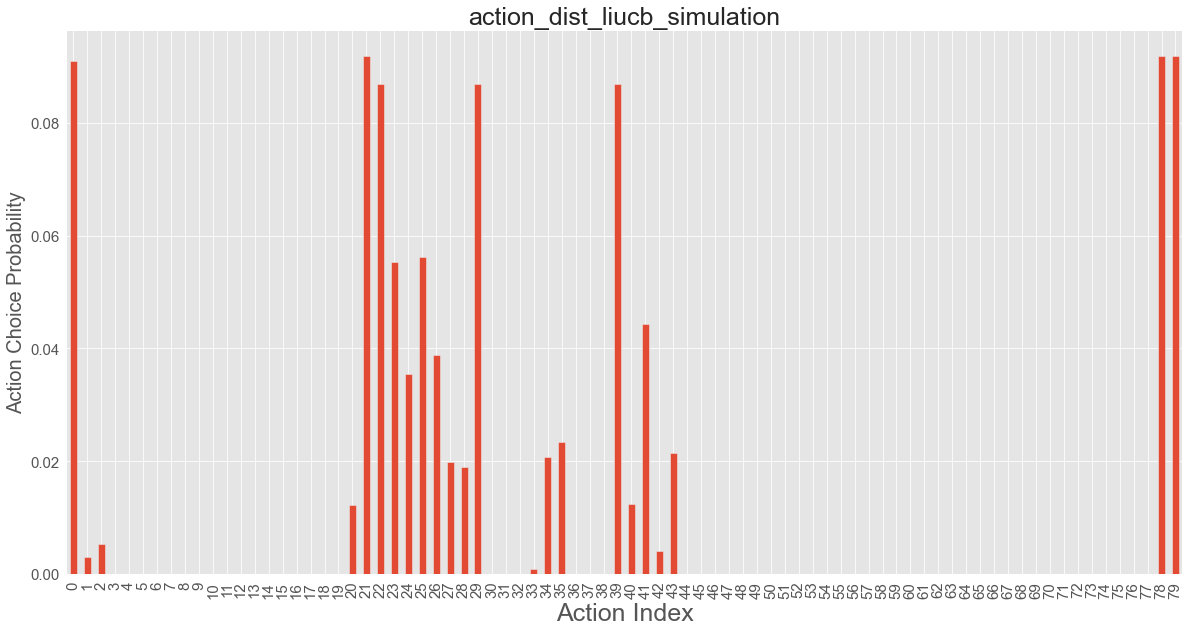

In [71]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(25, 15))


pd.Series(action_dist_liucb_simulation.mean(axis=0).mean(axis=1)).plot(kind='bar', figsize=(20,10), ax=ax)

plt.title(f"action_dist_liucb_simulation", fontsize=25)

plt.xlabel("Action Index", fontsize=25)

plt.ylabel(
    f"Action Choice Probability", fontsize=20
)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.savefig(str(Path.cwd() / "action_dist_liucb_simulation.png"))

### Testing LinEpsilonGreedy - contextual (non production)

In [91]:
# define BernoulliTS as an evaluation policy
evaluation_policy_lineg_simulation = LinEpsilonGreedy(
    dim=dataset_random_all.dim_context,
    n_actions=dataset_random_all.n_actions,
    len_list=dataset_random_all.len_list,
    batch_size=100,
    random_state=12345,
    epsilon=0.1
)

evaluation_policy_lineg_simulation

LinEpsilonGreedy(dim=24, n_actions=80, len_list=3, batch_size=100, random_state=12345, epsilon=0.1)

In [92]:
%%time

action_dist_lineg_simulation = run_bandit_simulation(
    bandit_feedback=bandit_feedback_random_all,
    policy=evaluation_policy_lineg_simulation,
)

100%|██████████| 30006/30006 [00:07<00:00, 4250.13it/s]

CPU times: user 6.89 s, sys: 250 ms, total: 7.14 s
Wall time: 7.13 s


In [93]:
action_dist_lineg_simulation[0].T

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

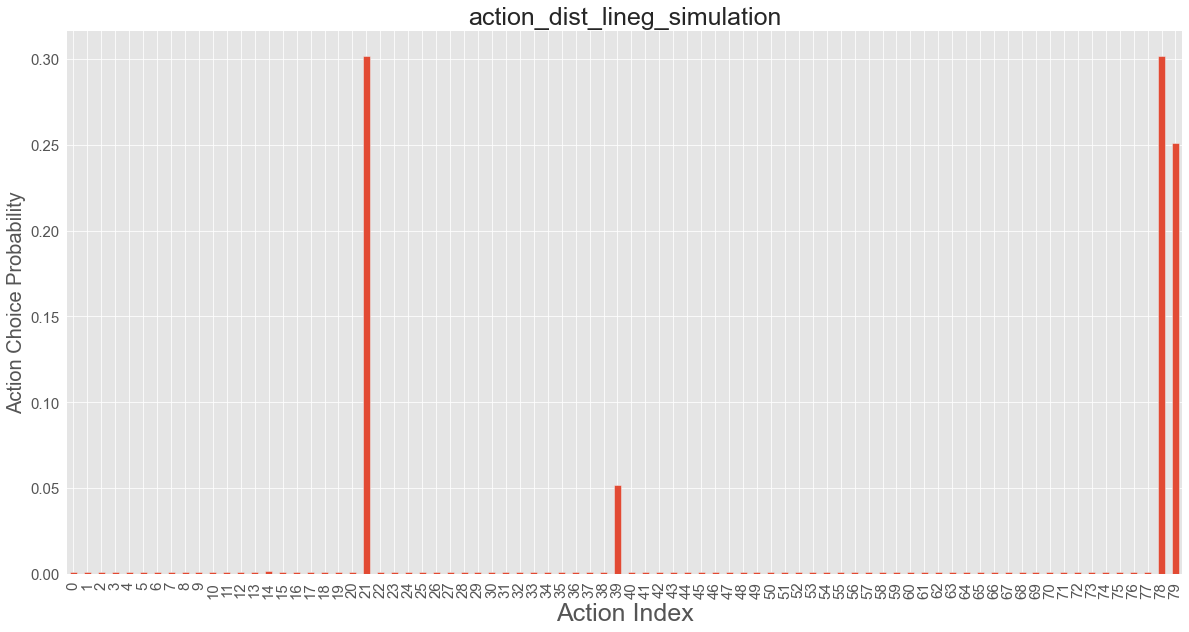

In [94]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(25, 15))


pd.Series(action_dist_lineg_simulation.mean(axis=0).mean(axis=1)).plot(kind='bar', figsize=(20,10), ax=ax)

plt.title(f"action_dist_lineg_simulation", fontsize=25)

plt.xlabel("Action Index", fontsize=25)

plt.ylabel(
    f"Action Choice Probability", fontsize=20
)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.savefig(str(Path.cwd() / "action_dist_lineg_simulation.png"))

### Testing LogisticTS - contextual (non production)

In [57]:
# define BernoulliTS as an evaluation policy
evaluation_policy_logts_simulation = LogisticTS(
    dim=dataset_random_all.dim_context,
    n_actions=dataset_random_all.n_actions,
    len_list=dataset_random_all.len_list,
    batch_size=100,
    random_state=12345,
)

evaluation_policy_logts_simulation

LogisticTS(dim=24, n_actions=80, len_list=3, batch_size=100, random_state=12345, alpha_=1.0, lambda_=1.0, policy_name='logistic_ts')

In [ ]:
evaluation_policy_logts_simulation.policy_name

In [58]:
%%time

action_dist_logts_simulation = run_bandit_simulation(
    bandit_feedback=bandit_feedback_random_all,
    policy=evaluation_policy_logts_simulation,
)

100%|██████████| 30006/30006 [01:27<00:00, 344.58it/s]


CPU times: user 1min 21s, sys: 6.26 s, total: 1min 28s
Wall time: 1min 27s


In [59]:
action_dist_logts_simulation[0].T

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

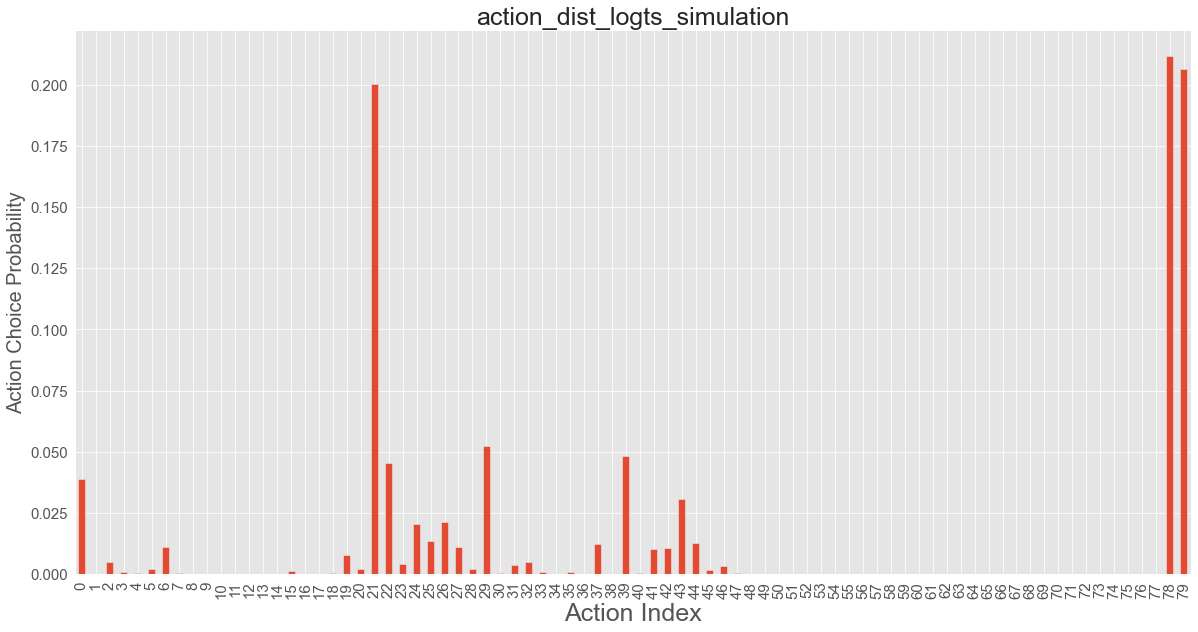

In [60]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(25, 15))


pd.Series(action_dist_logts_simulation.mean(axis=0).mean(axis=1)).plot(kind='bar', figsize=(20,10), ax=ax)

plt.title(f"action_dist_logts_simulation", fontsize=25)

plt.xlabel("Action Index", fontsize=25)

plt.ylabel(
    f"Action Choice Probability", fontsize=20
)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.savefig(str(Path.cwd() / "action_dist_logts_simulation.png"))

### Testing LogisticUCB - contextual (non production)

In [100]:
# define BernoulliTS as an evaluation policy
evaluation_policy_logucb_simulation = LogisticUCB(
    dim=dataset_random_all.dim_context,
    n_actions=dataset_random_all.n_actions,
    len_list=dataset_random_all.len_list,
    batch_size=100,
    random_state=12345,
    epsilon=3.0
)

evaluation_policy_logucb_simulation

LogisticUCB(dim=24, n_actions=80, len_list=3, batch_size=100, random_state=12345, alpha_=1.0, lambda_=1.0, epsilon=3.0)

In [164]:
from obp.policy.policy_type import PolicyType

In [168]:
evaluation_policy_logucb_simulation.policy_type == PolicyType.CONTEXTUAL

True

In [101]:
%%time

action_dist_logucb_simulation = run_bandit_simulation(
    bandit_feedback=bandit_feedback_random_all,
    policy=evaluation_policy_logucb_simulation,
)

100%|██████████| 30006/30006 [00:48<00:00, 622.22it/s]

CPU times: user 45.8 s, sys: 3.56 s, total: 49.3 s
Wall time: 48.3 s


In [214]:
type(action_dist_logucb_simulation)

numpy.ndarray

In [102]:
action_dist_logucb_simulation[0].T

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

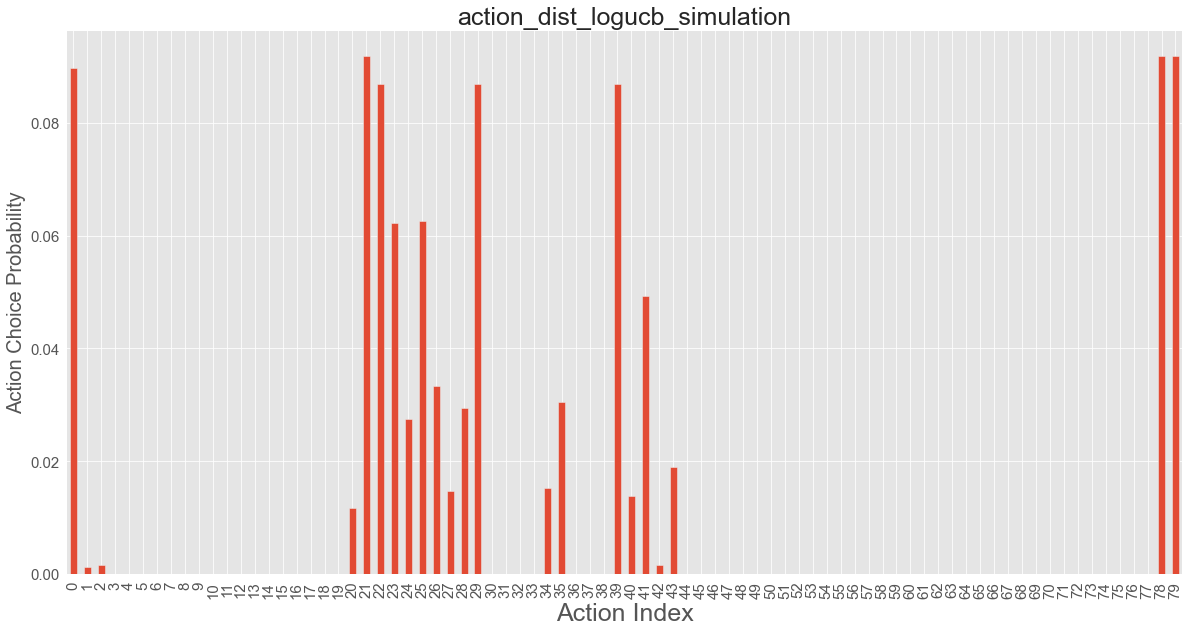

In [103]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(25, 15))


pd.Series(action_dist_logucb_simulation.mean(axis=0).mean(axis=1)).plot(kind='bar', figsize=(20,10), ax=ax)

plt.title(f"action_dist_logucb_simulation", fontsize=25)

plt.xlabel("Action Index", fontsize=25)

plt.ylabel(
    f"Action Choice Probability", fontsize=20
)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.savefig(str(Path.cwd() / "action_dist_logucb_simulation.png"))

In [198]:
def get_simulation_bandit_policy_list(
        obd_dataset: OpenBanditDataset):
    # general kwargs
    kwargs = dict(
        n_actions=obd_dataset.n_actions,
        len_list=obd_dataset.len_list,
        batch_size=100,
        random_state=12345
    )
    simulation_policy_list = [
        # - ContextFree -
        # - EpsilonGreedy -epsilon [0,1]
        EpsilonGreedy(epsilon=0.05, **kwargs),  # 5% exploration
        EpsilonGreedy(epsilon=0.1, **kwargs),  # 10% exploration
        Random(**kwargs),  # 100% exploration

        # - BernoulliTS -
        # prior weights
        BernoulliTS(
            policy_name="bts-obp",
            is_zozotown_prior=True,
            campaign="all",
            **kwargs
        ),
        # no-priors
        BernoulliTS(policy_name="bts", **kwargs),

        # - Contextual - Linear -

        # - LinEpsilonGreedy - epsilon [0,1]
        # 5% exploration
        LinEpsilonGreedy(
            dim=obd_dataset.dim_context,
            epsilon=0.05,
            **kwargs
        ),
        # 10% exploration
        LinEpsilonGreedy(
            dim=obd_dataset.dim_context,
            epsilon=0.1,
            **kwargs
        ),

        # - LinUCB - epsilon [0, inf]
        # epsilon 0
        LinUCB(
            dim=obd_dataset.dim_context,
            **kwargs
        ),
        # epsilon 1
        LinUCB(
            dim=obd_dataset.dim_context,
            epsilon=1.0,
            **kwargs
        ),
        # - LinTS -
        LinTS(
            dim=obd_dataset.dim_context,
            **kwargs
        ),

        # - Contextual - Logistic -

        # - LogisticEpsilonGreedy - epsilon [0,1]
        # 5% exploration
        LogisticEpsilonGreedy(
            dim=obd_dataset.dim_context,
            epsilon=0.05,
            **kwargs
        ),
        # 10% exploration
        LogisticEpsilonGreedy(
            dim=obd_dataset.dim_context,
            epsilon=0.1,
            **kwargs
        ),

        # - LogisticUCB -
        # epsilon [0,inf]
        LogisticUCB(
            dim=obd_dataset.dim_context,
            **kwargs
        ),
        # epsilon 1
        LogisticUCB(
            dim=obd_dataset.dim_context,
            epsilon=1.0,
            **kwargs
        ),

        # - LogisticTS -
        LogisticTS(
            dim=obd_dataset.dim_context,
            **kwargs
        ),
    ]
    return simulation_policy_list

In [200]:
len(get_simulation_bandit_policy_list(obd_dataset=dataset_random_all))

15

In [211]:
for bandit_policy in get_simulation_bandit_policy_list(obd_dataset=dataset_random_all):
    policy_class_name = str(bandit_policy.__class__).split(".")[-1]

    print(policy_class_name, bandit_policy.policy_name)

EpsilonGreedy'> egreedy_0.05
EpsilonGreedy'> egreedy_0.1
Random'> egreedy_1.0
BernoulliTS'> bts-obp
BernoulliTS'> bts
LinEpsilonGreedy'> linear_epsilon_greedy_0.05
LinEpsilonGreedy'> linear_epsilon_greedy_0.1
LinUCB'> linear_ucb_0.0
LinUCB'> linear_ucb_1.0
LinTS'> linear_ts
LogisticEpsilonGreedy'> logistic_egreedy_0.05
LogisticEpsilonGreedy'> logistic_egreedy_0.1
LogisticUCB'> logistic_ucb_0.0
LogisticUCB'> logistic_ucb_1.0
LogisticTS'> logistic_ts


## (3) Off-Policy Evaluation (OPE)
Our next step is OPE, which aims to estimate the performance of evaluation policies using logged bandit data and OPE estimators.

Here, we use 
- `obp.ope.InverseProbabilityWeighting` (IPW)
- `obp.ope.DirectMethod` (DM)
- `obp.ope.DoublyRobust` (DR)

as estimators and visualize the OPE results.

### (3-1) Obtaining a reward estimator
A reward estimator $\hat{q}(x,a)$ is needed for model dependent estimators such as DM or DR.

$\hat{q}(x,a) \approx \mathbb{E} [r \mid x,a]$

please refer to https://arxiv.org/abs/2002.08536 about the details of the cross-fitting procedure.

In [119]:
# estimate the expected rewards by using an ML model (Logistic Regression here)
# the estimated rewards are used by model-dependent estimators such as DM and DR
regression_model_lr = RegressionModel(
    n_actions=dataset_random_all.n_actions,
    len_list=dataset_random_all.len_list,
    action_context=dataset_random_all.action_context,
    base_model=LogisticRegression(max_iter=1000, random_state=12345),
)

regression_model_lr

RegressionModel(base_model=LogisticRegression(max_iter=1000, random_state=12345), n_actions=80, len_list=3, action_context=array([[ 9.00000000e+00,  6.00000000e+00,  1.00000000e+00,
        -4.99171626e-01],
       [ 1.00000000e+01,  6.00000000e+00,  1.00000000e+00,
        -5.43775368e-01],
       [ 1.00000000e+01,  8.00000000e+00,  6.00000000e+00,
         9.72751855e-01],
       [ 1.10000000e+01,  1.00000000e+00,  3.00000000e+00,
        -5.21473497e-01],
       [ 3.00000000e+00,  1.90000000e+01,  6.00000000e+00,
         1.90943043e+00],
       [ 1.10000000e+01,  6.00000000e+00,  1.00000000e+00,
        -4.99171626e-01],
       [ 9.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         3.48299469e-01],
       [ 0.00000000e+00,  6.00000000e+00,  1.00000000e+00,
        -2.76152917e-01],
       [ 1.10000000e+01,  1.60000000e+01,  1.00000000e+00,
        -6.55284723e-01],
       [ 9.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        -3.87662271e-01],
       [ 3.00000000e+00,  1

In [120]:
# please refer to https://arxiv.org/abs/2002.08536 about the details of the cross-fitting procedure

estimated_rewards_by_reg_model_lr = regression_model_lr.fit_predict(
    context=bandit_feedback_random_all["context"],
    action=bandit_feedback_random_all["action"],
    reward=bandit_feedback_random_all["reward"],
    position=bandit_feedback_random_all["position"],
    pscore=bandit_feedback_random_all["pscore"],
    n_folds=3, # use 3-fold cross-fitting
    random_state=12345,
)

estimated_rewards_by_reg_model_lr.shape

(30006, 80, 3)

In [121]:
estimated_rewards_by_reg_model_lr[0].T

array([[0.00555852, 0.00531874, 0.00373409, 0.00436714, 0.00504385,
        0.00512378, 0.00669526, 0.00815113, 0.00481364, 0.00521936,
        0.00730214, 0.00411303, 0.00586165, 0.00534124, 0.00371457,
        0.00382948, 0.00447205, 0.00400986, 0.00353068, 0.00472499,
        0.00445898, 0.00434002, 0.0039665 , 0.00406224, 0.00411064,
        0.00415962, 0.00436714, 0.00577968, 0.00436719, 0.00517329,
        0.00532629, 0.00526365, 0.00475646, 0.00475646, 0.00697417,
        0.00697417, 0.00635395, 0.00591637, 0.00402224, 0.00559378,
        0.00521936, 0.00637564, 0.00612768, 0.00430347, 0.00383449,
        0.00510661, 0.00610475, 0.00743587, 0.00581792, 0.00431052,
        0.00498852, 0.00548287, 0.00725248, 0.00477182, 0.00536428,
        0.00657425, 0.00536428, 0.00421362, 0.00540879, 0.00387697,
        0.00540267, 0.00565323, 0.00680103, 0.0086914 , 0.00694324,
        0.0051434 , 0.00708129, 0.00521112, 0.00379779, 0.00442974,
        0.00458163, 0.00543006, 0.00537535, 0.00

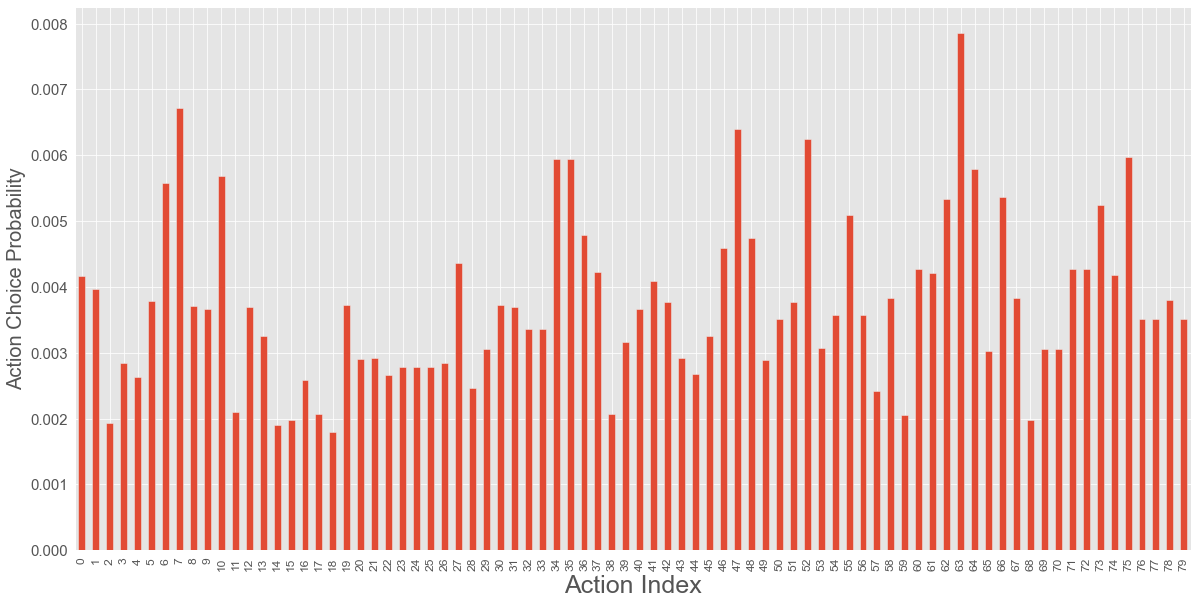

In [122]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(20, 10))

pd.Series(estimated_rewards_by_reg_model_lr.mean(axis=0).mean(axis=1)).plot(kind='bar', ax=ax)

plt.xlabel("Action Index", fontsize=25)

plt.ylabel(
    f"Action Choice Probability", fontsize=20
)

plt.yticks(fontsize=15)
plt.xticks(fontsize=12)

plt.savefig(str(Path.cwd() / "Reward_action_choice_probability.png"))

### (3-2) Off-Policy Evaluation
$V(\pi_e) \approx \hat{V} (\pi_e; \mathcal{D}_b, \theta)$ using DM, IPW, and DR

In [197]:
# estimate the policy value of BernoulliTS based on its action choice probabilities
# it is possible to set multiple OPE estimators to the `ope_estimators` argument

ope_estimators = [
    # standard methods
    DirectMethod(estimator_name='dm'),
    InverseProbabilityWeighting(estimator_name='ipw'),
    DoublyRobust(estimator_name='dr'),

    # self normalized methods
    SelfNormalizedInverseProbabilityWeighting(estimator_name='snipw'),
    SelfNormalizedDoublyRobust(estimator_name='sndr'),
    # BalancedInverseProbabilityWeighting(estimator_name='b-ipw'),

    # tuned methods
    # classic tuned methods
    InverseProbabilityWeightingTuning(lambdas=[10, 50, 100, 500, 1000, 5000, 10000, np.inf], estimator_name='ipw-t'),
    DoublyRobustTuning(lambdas=[10, 50, 100, 500, 1000, 5000, 10000, np.inf], estimator_name='dr-t'),

    # recent tuned methods
    SwitchDoublyRobustTuning(lambdas=[10, 50, 100, 500, 1000, 5000, 10000, np.inf], estimator_name='switch-dr-t'),
    DoublyRobustWithShrinkageTuning(lambdas=[10, 50, 100, 500, 1000, 5000, 10000, np.inf], estimator_name='dr-os-t'),
    SubGaussianDoublyRobustTuning(lambdas=[0.0, 0.25, 0.5, 0.75, 1.0], estimator_name='sg-dr-t'),
    SubGaussianInverseProbabilityWeightingTuning(lambdas=[0.0, 0.25, 0.5, 0.75, 1.0], estimator_name='sg-ipw-t'),
]


ope_random_all = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback_random_all,
    ope_estimators=ope_estimators
)

ope_random_all

OffPolicyEvaluation(bandit_feedback={'n_rounds': 30006, 'n_actions': 80, 'action': array([45, 48,  8, ..., 38, 40, 57]), 'position': array([0, 2, 1, ..., 2, 1, 0]), 'reward': array([0, 0, 0, ..., 0, 0, 0]), 'pscore': array([0.0125, 0.0125, 0.0125, ..., 0.0125, 0.0125, 0.0125]), 'context': array([[0, 1, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1]], dtype=uint8), 'action_context': array([[ 9.00000000e+00,  6.00000000e+00,  1.00000000e+00,
        -4.99171626e-01],
       [ 1.00000000e+01,  6.00000000e+00,  1.00000000e+00,
        -5.43775368e-01],
       [ 1.00000000e+01,  8.00000000e+00,  6.00000000e+00,
         9.72751855e-01],
       [ 1.10000000e+01,  1.00000000e+00,  3.00000000e+00,
        -5.21473497e-01],
       [ 3.00000000e+00,  1.90000000e+01,  6.00000000e+00,
         1.90943043e+00],
       [ 1.10000000e+01,  6.00000000e+00,  1.000

#### BTS Prior ZozoTown Weights

In [124]:
# `summarize_off_policy_estimates` returns pandas dataframes including the OPE results
estimated_policy_value_berts_prior_wrights, estimated_interval_berts_prior_wrights = ope_random_all.summarize_off_policy_estimates(
    action_dist=action_dist_berts_prior_wrights,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
    n_bootstrap_samples=10000, # number of resampling performed in bootstrap sampling.
    random_state=12345,
)

# the estimated policy value of the evaluation policy (the BernoulliTS policy)
# relative_estimated_policy_value is the policy value of the evaluation policy relative to the ground-truth policy value of the behavior policy (the Random policy here)
estimated_policy_value_berts_prior_wrights

,estimated_policy_value,relative_estimated_policy_value
dm,0.004177,1.109269
ipw,0.005472,1.453055
dr,0.005382,1.429247
snipw,0.005400,1.433984
sndr,0.005367,1.425047
ipw-t,0.004832,1.283172
dr-t,0.005148,1.367006
switch-dr-t,0.005020,1.332969
dr-os-t,0.004532,1.203296
sg-dr-t,0.004501,1.195191


In [125]:
# confidence intervals of policy value of BernoulliTS estimated by OPE estimators
# (`mean` values in this dataframe is also estimated via the non-parametric bootstrap procedure
# and is a bit different from the above values in `estimated_policy_value`)
estimated_interval_berts_prior_wrights

,mean,95.0% CI (lower),95.0% CI (upper)
dm,0.004177,0.004148,0.004207
ipw,0.005475,0.003434,0.007959
dr,0.005386,0.003360,0.007876
snipw,0.005403,0.003389,0.007855
sndr,0.005370,0.003371,0.007827
ipw-t,0.004835,0.003294,0.006598
dr-t,0.005152,0.003604,0.006922
switch-dr-t,0.005024,0.003713,0.006460
dr-os-t,0.004530,0.003992,0.005100
sg-dr-t,0.004500,0.003926,0.005102


In [127]:
estimated_interval_berts_prior_wrights.T

,dm,ipw,dr,snipw,sndr,ipw-t,dr-t,switch-dr-t,dr-os-t,sg-dr-t,sg-ipw-t
mean,0.004177,0.005475,0.005386,0.005403,0.005370,0.004835,0.005152,0.005024,0.004530,0.004500,0.003765
95.0% CI (lower),0.004148,0.003434,0.003360,0.003389,0.003371,0.003294,0.003604,0.003713,0.003992,0.003926,0.003066
95.0% CI (upper),0.004207,0.007959,0.007876,0.007855,0.007827,0.006598,0.006922,0.006460,0.005100,0.005102,0.004466


In [128]:
pd.concat([estimated_policy_value_berts_prior_wrights, estimated_interval_berts_prior_wrights], axis=1)

,estimated_policy_value,relative_estimated_policy_value,mean,95.0% CI (lower),95.0% CI (upper)
dm,0.004177,1.109269,0.004177,0.004148,0.004207
ipw,0.005472,1.453055,0.005475,0.003434,0.007959
dr,0.005382,1.429247,0.005386,0.003360,0.007876
snipw,0.005400,1.433984,0.005403,0.003389,0.007855
sndr,0.005367,1.425047,0.005370,0.003371,0.007827
ipw-t,0.004832,1.283172,0.004835,0.003294,0.006598
dr-t,0.005148,1.367006,0.005152,0.003604,0.006922
switch-dr-t,0.005020,1.332969,0.005024,0.003713,0.006460
dr-os-t,0.004532,1.203296,0.004530,0.003992,0.005100
sg-dr-t,0.004501,1.195191,0.004500,0.003926,0.005102


In [249]:
estimated_interval_berts_prior_wrights.T

,dm,ipw,dr,snipw,sndr,ipw-t,dr-t,switch-dr-t,dr-os-t,sg-dr-t,sg-ipw-t
mean,0.004177,0.005475,0.005386,0.005403,0.005370,0.004835,0.005152,0.005024,0.004530,0.004500,0.003765
95.0% CI (lower),0.004148,0.003434,0.003360,0.003389,0.003371,0.003294,0.003604,0.003713,0.003992,0.003926,0.003066
95.0% CI (upper),0.004207,0.007959,0.007876,0.007855,0.007827,0.006598,0.006922,0.006460,0.005100,0.005102,0.004466


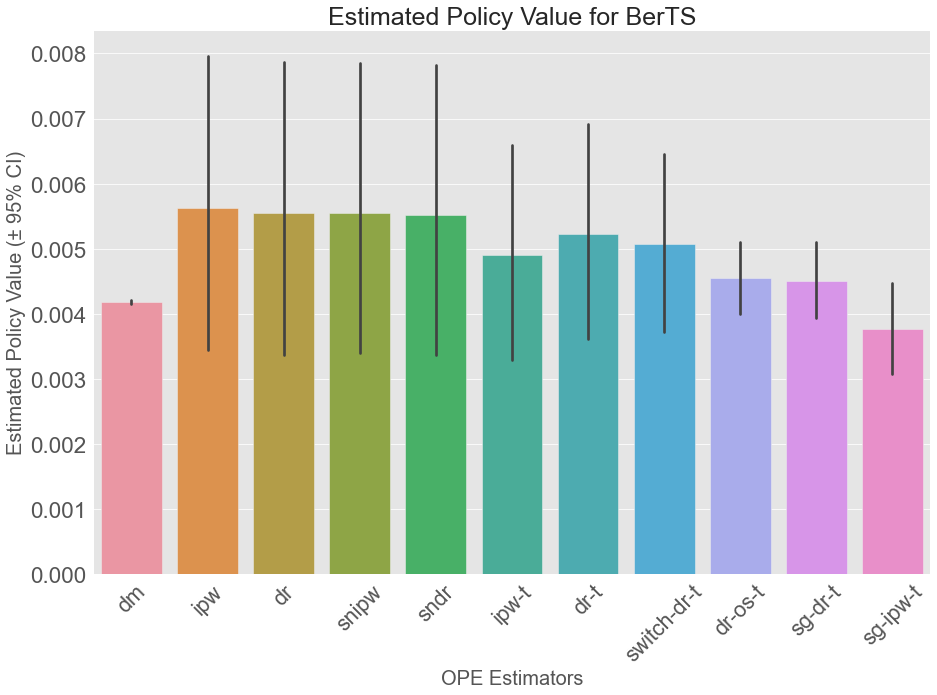

In [129]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(15, 10))

# sns.barplot(data=estimated_interval_berts_prior_wrights.T, ax=ax)
plt.errorbar( df['Model'], df['Mean'], yerr=df['SD'], fmt='o', color='Black', elinewidth=3,capthick=3,errorevery=1, alpha=1, ms=4, capsize = 5)
plt.bar(df['Model'], df['Mean'], tick_label = df['Model'])

plt.title(f"Estimated Policy Value for BerTS", fontsize=25)

plt.xlabel("OPE Estimators", fontsize=20)
plt.ylabel(f"Estimated Policy Value (± 95% CI)", fontsize=20)

plt.yticks(fontsize=22.5)
plt.xticks(fontsize=32.5 - len(ope_estimators), rotation = 45)

# fig.savefig(str(Path.cwd() / "bts_prod_ope.png"))
# plt.show()
plt.savefig(str(Path.cwd() / "bts_prod_ope.png"))

In [130]:
bandit_feedback_random_all["reward"].mean()

0.0037659134839698725

In [131]:
estimated_interval_berts_prior_wrights.T / bandit_feedback_random_all["reward"].mean()

,dm,ipw,dr,snipw,sndr,ipw-t,dr-t,switch-dr-t,dr-os-t,sg-dr-t,sg-ipw-t
mean,1.109182,1.453728,1.430223,1.434649,1.42601,1.283963,1.368050,1.334099,1.202771,1.194805,0.999738
95.0% CI (lower),1.101536,0.911930,0.892184,0.899961,0.89501,0.874657,0.956914,0.986042,1.060123,1.042449,0.814159
95.0% CI (upper),1.117087,2.113523,2.091259,2.085784,2.07830,1.751930,1.838011,1.715441,1.354140,1.354850,1.185841


In [248]:
estimated_interval_berts_prior_wrights.T / bandit_feedback_random_all["reward"].mean()

,dm,ipw,dr,snipw,sndr,ipw-t,dr-t,switch-dr-t,dr-os-t,sg-dr-t,sg-ipw-t
mean,1.109182,1.453728,1.430223,1.434649,1.42601,1.283963,1.368050,1.334099,1.202771,1.194805,0.999738
95.0% CI (lower),1.101536,0.911930,0.892184,0.899961,0.89501,0.874657,0.956914,0.986042,1.060123,1.042449,0.814159
95.0% CI (upper),1.117087,2.113523,2.091259,2.085784,2.07830,1.751930,1.838011,1.715441,1.354140,1.354850,1.185841


In [245]:
bandit_feedback_random_all["reward"].mean()

0.0037659134839698725

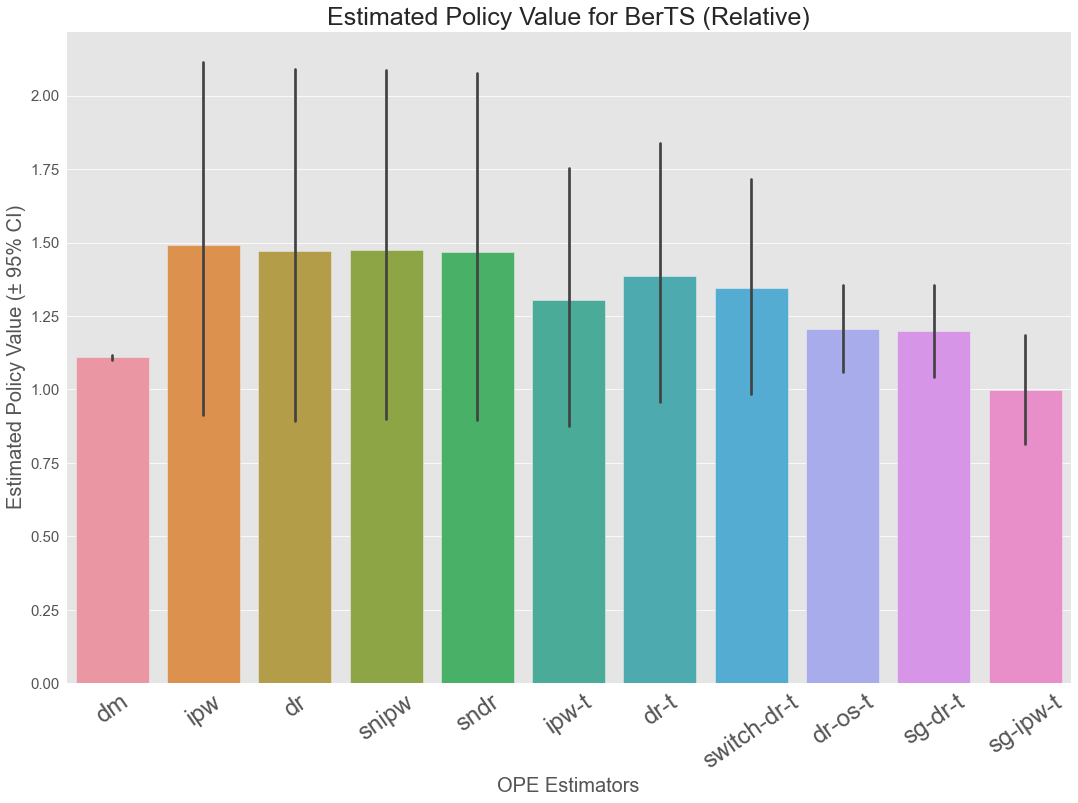

In [243]:
# RELATIVE

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(18, 12))

sns.barplot(
    data= estimated_interval_berts_prior_wrights.T / bandit_feedback_random_all["reward"].mean(),
)

plt.title(f"Estimated Policy Value for BerTS (Relative)", fontsize=25)

plt.xlabel("OPE Estimators", fontsize=20)
plt.ylabel(f"Estimated Policy Value (± 95% CI)", fontsize=20)

plt.yticks(fontsize=15)
plt.xticks(fontsize=35 - len(ope_estimators), rotation=35)

plt.show()
# if fig_dir:
#     fig.savefig(str(fig_dir / fig_name))

In [133]:
# # visualize the estimated policy values of BernoulliTS and their 95% confidence intervals (estimated by bootstrap)
# ope_random_all.visualize_off_policy_estimates(
#     action_dist=action_dist_berts_prior_wrights,
#     estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
#     n_bootstrap_samples=10000, # number of resampling performed in bootstrap sampling
#     random_state=12345,
# )

AttributeError: 'InverseProbabilityWeightingTuning' object has no attribute '_estimate_round_rewards'

In [209]:
# # by activating the `is_relative` option
# # we can visualize the estimated policy value of the evaluation policy
# # relative to the ground-truth policy value of the behavior policy
# ope_random_all.visualize_off_policy_estimates(
#     action_dist=action_dist_berts_prior_wrights,
#     estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
#     n_bootstrap_samples=10000, # number of resampling performed in bootstrap sampling
#     is_relative=True,
#     random_state=12345,
# )

AttributeError: 'SubGaussianDoublyRobustTuning' object has no attribute '_estimate_round_rewards'

#### BTS Simulation

In [134]:
# `summarize_off_policy_estimates` returns pandas dataframes including the OPE results
estimated_policy_value_berts_simulation, estimated_interval_berts_simulation = ope_random_all.summarize_off_policy_estimates(
    action_dist=action_dist_berts_simulation,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
    n_bootstrap_samples=100, # number of resampling performed in bootstrap sampling.
    random_state=12345,
)

# the estimated policy value of the evaluation policy (the BernoulliTS policy)
# relative_estimated_policy_value is the policy value of the evaluation policy relative to the ground-truth policy value of the behavior policy (the Random policy here)
estimated_policy_value_berts_simulation

/Users/mudev/opt/anaconda3/envs/ope-obp/lib/python3.9/site-packages/obp/ope/estimators.py:1871: RuntimeWarning: invalid value encountered in true_divide
  iw_hat = iw / (1 - self.lambda_ + self.lambda_ * iw)
/Users/mudev/opt/anaconda3/envs/ope-obp/lib/python3.9/site-packages/obp/ope/estimators.py:1871: RuntimeWarning: invalid value encountered in true_divide
  iw_hat = iw / (1 - self.lambda_ + self.lambda_ * iw)


,estimated_policy_value,relative_estimated_policy_value
dm,0.003785,1.004964
ipw,0.000000,0.000000
dr,-0.000466,-0.123709
snipw,0.000000,0.000000
sndr,-0.000152,-0.040313
ipw-t,0.000000,0.000000
dr-t,0.003253,0.863880
switch-dr-t,0.003785,1.004964
dr-os-t,0.003778,1.003203
sg-dr-t,0.003714,0.986231


In [135]:
# confidence intervals of policy value of BernoulliTS estimated by OPE estimators
# (`mean` values in this dataframe is also estimated via the non-parametric bootstrap procedure
# and is a bit different from the above values in `estimated_policy_value`)
estimated_interval_berts_simulation

,mean,95.0% CI (lower),95.0% CI (upper)
dm,0.003785,0.003753,0.003828
ipw,0.000000,0.000000,0.000000
dr,-0.000423,-0.000934,0.000135
snipw,0.000000,0.000000,0.000000
sndr,-0.000112,-0.000587,0.000407
ipw-t,0.000000,0.000000,0.000000
dr-t,0.003259,0.003187,0.003342
switch-dr-t,0.003785,0.003753,0.003828
dr-os-t,0.003778,0.003746,0.003822
sg-dr-t,0.003715,0.003681,0.003758


In [136]:
# visualize the estimated policy values of BernoulliTS and their 95% confidence intervals (estimated by bootstrap)
ope_random_all.visualize_off_policy_estimates(
    action_dist=action_dist_berts_simulation,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
    n_bootstrap_samples=100, # number of resampling performed in bootstrap sampling
    random_state=12345,
)

AttributeError: 'InverseProbabilityWeightingTuning' object has no attribute '_estimate_round_rewards'

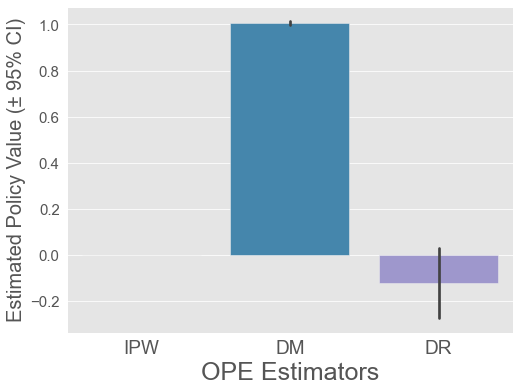

In [160]:
# by activating the `is_relative` option
# we can visualize the estimated policy value of the evaluation policy
# relative to the ground-truth policy value of the behavior policy
ope_random_all.visualize_off_policy_estimates(
    action_dist=action_dist_berts_simulation,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
    n_bootstrap_samples=100, # number of resampling performed in bootstrap sampling
    is_relative=True,
    random_state=12345,
)

Note that the OPE demonstration here is with the small size example version of our dataset. 

Please use its full size version (https://research.zozo.com/data.html) to produce more reasonable results.

#### LinTS Simulation

In [137]:
# `summarize_off_policy_estimates` returns pandas dataframes including the OPE results
estimated_policy_value_lints_simulation, estimated_interval_lints_simulation = ope_random_all.summarize_off_policy_estimates(
    action_dist=action_dist_lints_simulation,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
    n_bootstrap_samples=10000, # number of resampling performed in bootstrap sampling.
    random_state=12345,
)

# the estimated policy value of the evaluation policy (the BernoulliTS policy)
# relative_estimated_policy_value is the policy value of the evaluation policy relative to the ground-truth policy value of the behavior policy (the Random policy here)
estimated_policy_value_lints_simulation

/Users/mudev/opt/anaconda3/envs/ope-obp/lib/python3.9/site-packages/obp/ope/estimators.py:1871: RuntimeWarning: invalid value encountered in true_divide
  iw_hat = iw / (1 - self.lambda_ + self.lambda_ * iw)
/Users/mudev/opt/anaconda3/envs/ope-obp/lib/python3.9/site-packages/obp/ope/estimators.py:1871: RuntimeWarning: invalid value encountered in true_divide
  iw_hat = iw / (1 - self.lambda_ + self.lambda_ * iw)


,estimated_policy_value,relative_estimated_policy_value
dm,0.003745,0.994565
ipw,0.005332,1.415929
dr,0.005626,1.493846
snipw,0.005780,1.534912
sndr,0.005784,1.535801
ipw-t,0.000667,0.176991
dr-t,0.003980,1.056975
switch-dr-t,0.003745,0.994565
dr-os-t,0.003748,0.995344
sg-dr-t,0.003777,1.002852


In [171]:
# confidence intervals of policy value of BernoulliTS estimated by OPE estimators
# (`mean` values in this dataframe is also estimated via the non-parametric bootstrap procedure
# and is a bit different from the above values in `estimated_policy_value`)
estimated_interval_lints_simulation.T

,ipw,dm,dr
mean,0.005358,0.003776,0.005827
95.0% CI (lower),0.000000,0.003741,0.000293
95.0% CI (upper),0.013331,0.003811,0.013956


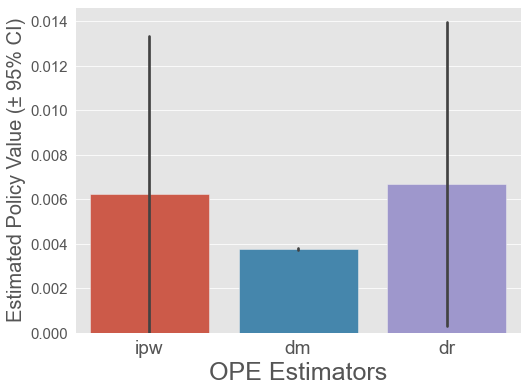

In [172]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=estimated_interval_lints_simulation.T,
)

plt.xlabel("OPE Estimators", fontsize=25)

plt.ylabel(
    f"Estimated Policy Value (± 95% CI)", fontsize=20
)

plt.yticks(fontsize=15)
plt.xticks(fontsize=25 - 2 * len(ope_estimators))


# plt.show()
plt.savefig(str(Path.cwd() / "lints_ope.png"))

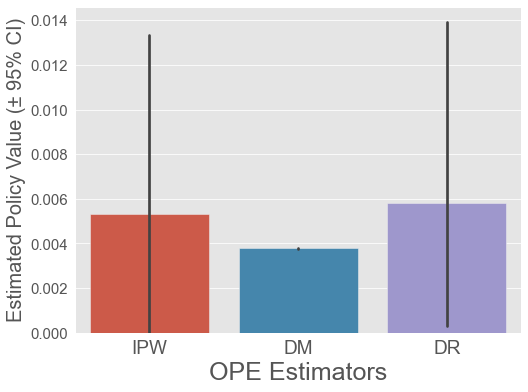

In [170]:
# visualize the estimated policy values of BernoulliTS and their 95% confidence intervals (estimated by bootstrap)
ope_random_all.visualize_off_policy_estimates(
    action_dist=action_dist_lints_simulation,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
    n_bootstrap_samples=10000, # number of resampling performed in bootstrap sampling
    random_state=12345,
)

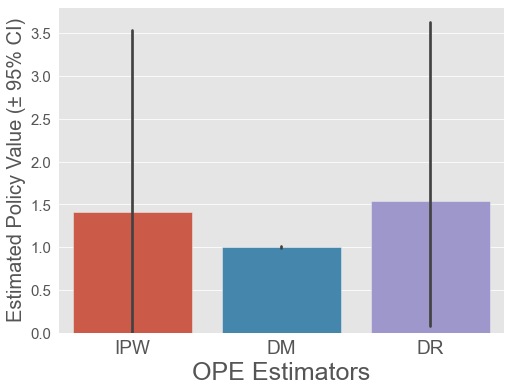

In [173]:
# by activating the `is_relative` option
# we can visualize the estimated policy value of the evaluation policy
# relative to the ground-truth policy value of the behavior policy
ope_random_all.visualize_off_policy_estimates(
    action_dist=action_dist_lints_simulation,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
    n_bootstrap_samples=100, # number of resampling performed in bootstrap sampling
    is_relative=True,
    random_state=12345,
)

#### Trying `visualize_off_policy_estimates_of_multiple_policies`

- this method only works with 2 OPE methodologies

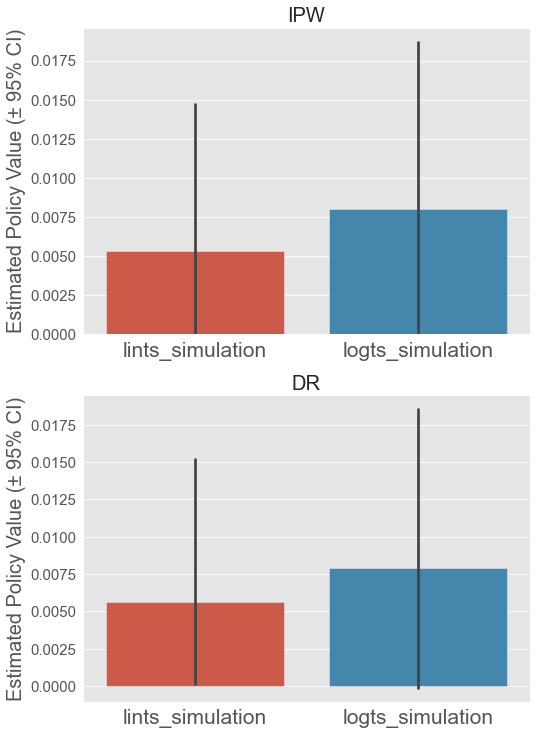

In [148]:
ope1 = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback_random_all,
    ope_estimators=[InverseProbabilityWeighting(), DoublyRobust()]
)

ope1.visualize_off_policy_estimates_of_multiple_policies(
    policy_name_list=[
        # "bts_prior_weights",
        "lints_simulation",
        # "linucb_simulation",
        "logts_simulation",
        # "logucb_simulation"
    ],
    action_dist_list=[
        # action_dist_berts_prior_wrights,
        action_dist_lints_simulation,
        # action_dist_liucb_simulation,
        action_dist_logts_simulation,
        # action_dist_logucb_simulation
    ],
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
    n_bootstrap_samples=100,
    random_state=12345,
)

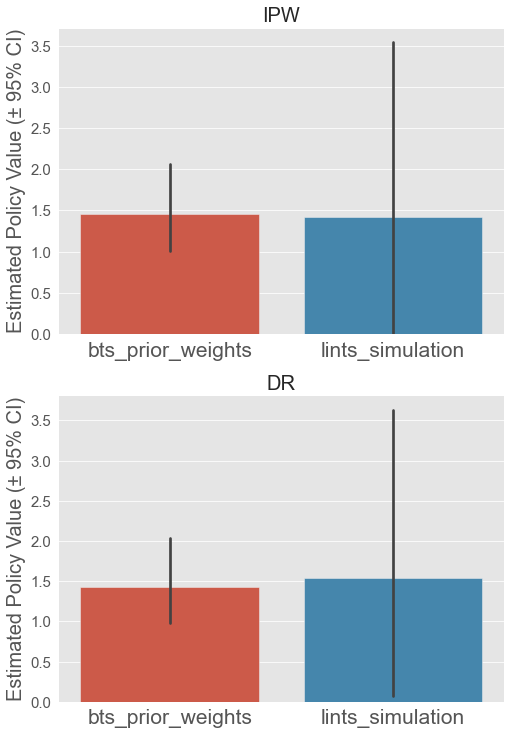

In [175]:
ope1 = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback_random_all,
    ope_estimators=[InverseProbabilityWeighting(), DoublyRobust()]
)

ope1.visualize_off_policy_estimates_of_multiple_policies(
    policy_name_list=["bts_prior_weights", "lints_simulation"],
    action_dist_list=[action_dist_berts_prior_wrights, action_dist_lints_simulation],
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
    n_bootstrap_samples=100,
    random_state=12345,
    is_relative=True
)

## (4) Evaluation of OPE

Our final step is the **evaluation of OPE**, which evaluates the estimation accuracy of OPE estimators.

Specifically, we asses the accuracy of DM, IPW, and DR by comparing their estimations with the ground-truth policy value estimated via the on-policy estimation from Open Bandit Dataset.

**This type of evaluation of OPE is possible, because Open Bandit Dataset contains a set of *multiple* different logged bandit datasets collected by running different policies on the same platform at the same time.**

Please refer to [the documentation](https://zr-obp.readthedocs.io/en/latest/evaluation_ope.html) for the details about the evaluation of OPE protocol.

### (4-1) Approximate the Ground-truth Policy Value 
With Open Bandit Dataset, we can estimate the ground-truth policy value of the evaluation policy in an on-policy manner as follows.

$V(\pi_e) \approx \frac{1}{|\mathcal{D}_{e}|} \sum_{i=1}^{|\mathcal{D}_{e}|} \mathbb{E}_{n} [r_i]$

$ \mathcal{D}_e := \{(x_i,a_i,r_i)\} $ ($(x,a,r) \sim p(x)\pi_e(a | x)p(r | x,a) $) is the log data collected by the evaluation policy (, which is used only for approximating the ground-truth policy value).

We can compare the policy values estimated by OPE estimators with this on-policy estimate to evaluate the accuracy of OPE.

In [210]:
# we first calculate the ground-truth policy value of the evaluation policy
# , which is estimated by averaging the factual / Empirical (observed) rewards contained in the dataset (on-policy estimation)
policy_value_bts_online = OpenBanditDataset.calc_on_policy_policy_value_estimate(
    behavior_policy='bts', campaign='all', data_path=data_path_complete
)

In [211]:
policy_value_bts_online

0.004953225649823585

In [101]:
# other way - using raw data

# dataset_bts_all.obtain_batch_bandit_feedback()["reward"].mean()

0.004953225649823585

In [107]:
# Baseline policy Value

# dataset_random_all.obtain_batch_bandit_feedback()["reward"].mean()

0.0034693344451502445

### (4-2) Evaluation of OPE

We can evaluate the estimation performance of OPE estimators by comparing the estimated policy values of the evaluation with its ground-truth as follows.

- $\textit{relative-ee} (\hat{V}; \mathcal{D}_b) := \left| \frac{V(\pi_e) - \hat{V} (\pi_e; \mathcal{D}_b)}{V(\pi_e)} \right|$ (relative estimation error; relative-ee)
- $\textit{SE} (\hat{V}; \mathcal{D}_b) := \left( V(\pi_e) - \hat{V} (\pi_e; \mathcal{D}_b) \right)^2$ (squared error; se)


**We can iterate the above process several times to get more reliable results.**
- also mentioned in paper
- or here: https://zr-obp.readthedocs.io/en/latest/evaluation_ope.html

  - the above states that we can calculate the OPE performance on multiple bootstrapped datasets to get more robust results.

In [261]:
# evaluate the estimation performance of the OPE estimators 
# `evaluate_performance_of_estimators` returns a dictionary containing estimation performance of given estimators

relative_ee_random_all_bts_prior_weights = ope_random_all.summarize_estimators_comparison(
    ground_truth_policy_value=policy_value_bts_online,
    action_dist=action_dist_berts_prior_wrights,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower means accurate)
relative_ee_random_all_bts_prior_weights

,relative-ee
dm,0.156628
ipw,0.104751
dr,0.086649
snipw,0.090251
sndr,0.083457
ipw-t,0.024411
dr-t,0.039328
switch-dr-t,0.013450
dr-os-t,0.085140
sg-dr-t,0.094911


In [103]:
# se_random_all_bts_prior_weights = ope_random_all.summarize_estimators_comparison(
#     ground_truth_policy_value=policy_value_bts_online,
#     action_dist=action_dist_berts_prior_wrights,
#     estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
#     metric="se", #  "se" (squared error)
# )
#
# # estimation performances of the three estimators (lower means accurate)
# se_random_all_bts_prior_weights

#### Evaluation of OPE will not work for Offline Simulation because it requires TRUE Online Policy Value

In [104]:
# # evaluate the estimation performance of the OPE estimators
# # `evaluate_performance_of_estimators` returns a dictionary containing estimation performance of given estimators
#
# relative_ee_random_all_bts_simulation = ope_random_all.summarize_estimators_comparison(
#     ground_truth_policy_value=policy_value_bts_online,
#     action_dist=action_dist_berts_simulation,
#     estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
#     metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
# )
#
# # estimation performances of the three estimators (lower means accurate)
# relative_ee_random_all_bts_simulation



Please see [examples/obd](../obd) for a more sophisticated example of the evaluation of OPE with the Open Bandit Dataset.

## (5) Slate Off-Policy Evaluation (S-OPE)
Our next step is OPE, which aims to estimate the performance of evaluation policies using logged bandit data and OPE estimators.

Here, we use
- `SlateStandardIPS` (SIPS)
- `SlateIndependentIPS` (IIPS)
- `SlateRewardInteractionIPS` (RIPS)

and visualize the OPE results.

In [60]:
from obp.ope import SlateStandardIPS, SlateIndependentIPS, SlateRewardInteractionIPS, SlateOffPolicyEvaluation

In [83]:
dataset_random_all.len_list

3

In [62]:
bandit_feedback_random_all

{'n_rounds': 30006,
 'n_actions': 80,
 'action': array([45, 48,  8, ..., 38, 40, 57]),
 'position': array([0, 2, 1, ..., 2, 1, 0]),
 'reward': array([0, 0, 0, ..., 0, 0, 0]),
 'pscore': array([0.0125, 0.0125, 0.0125, ..., 0.0125, 0.0125, 0.0125]),
 'context': array([[0, 1, 0, ..., 1, 0, 0],
        [0, 1, 0, ..., 1, 0, 0],
        [0, 1, 0, ..., 1, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 1],
        [0, 1, 0, ..., 0, 0, 1],
        [0, 1, 0, ..., 0, 0, 1]], dtype=uint8),
 'action_context': array([[ 9.00000000e+00,  6.00000000e+00,  1.00000000e+00,
         -4.99171626e-01],
        [ 1.00000000e+01,  6.00000000e+00,  1.00000000e+00,
         -5.43775368e-01],
        [ 1.00000000e+01,  8.00000000e+00,  6.00000000e+00,
          9.72751855e-01],
        [ 1.10000000e+01,  1.00000000e+00,  3.00000000e+00,
         -5.21473497e-01],
        [ 3.00000000e+00,  1.90000000e+01,  6.00000000e+00,
          1.90943043e+00],
        [ 1.10000000e+01,  6.00000000e+00,  1.00000000e+00,
  

In [90]:
bandit_feedback_random_all['n_rounds'] = int(bandit_feedback_random_all['n_rounds']/dataset_random_all.len_list)

In [91]:
bandit_feedback_random_all

{'n_rounds': 10002,
 'n_actions': 80,
 'action': array([45, 48,  8, ..., 38, 40, 57]),
 'position': array([0, 2, 1, ..., 2, 1, 0]),
 'reward': array([0, 0, 0, ..., 0, 0, 0]),
 'pscore': array([0.0125, 0.0125, 0.0125, ..., 0.0125, 0.0125, 0.0125]),
 'context': array([[0, 1, 0, ..., 1, 0, 0],
        [0, 1, 0, ..., 1, 0, 0],
        [0, 1, 0, ..., 1, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 1],
        [0, 1, 0, ..., 0, 0, 1],
        [0, 1, 0, ..., 0, 0, 1]], dtype=uint8),
 'action_context': array([[ 9.00000000e+00,  6.00000000e+00,  1.00000000e+00,
         -4.99171626e-01],
        [ 1.00000000e+01,  6.00000000e+00,  1.00000000e+00,
         -5.43775368e-01],
        [ 1.00000000e+01,  8.00000000e+00,  6.00000000e+00,
          9.72751855e-01],
        [ 1.10000000e+01,  1.00000000e+00,  3.00000000e+00,
         -5.21473497e-01],
        [ 3.00000000e+00,  1.90000000e+01,  6.00000000e+00,
          1.90943043e+00],
        [ 1.10000000e+01,  6.00000000e+00,  1.00000000e+00,
  

In [73]:
# estimate the policy value of the evaluation policies based on their action choice probabilities
# it is possible to set multiple OPE estimators to the `ope_estimators` argument

sips = SlateStandardIPS(len_list=dataset_random_all.len_list)
iips = SlateIndependentIPS(len_list=dataset_random_all.len_list)
rips = SlateRewardInteractionIPS(len_list=dataset_random_all.len_list)

slate_ope = SlateOffPolicyEvaluation(
    bandit_feedback=bandit_feedback_random_all,
    ope_estimators=[sips, iips, rips]
)

In [92]:
# `summarize_off_policy_estimates` returns pandas dataframes including the OPE results

estimated_policy_value, estimated_interval = slate_ope.summarize_off_policy_estimates(
    evaluation_policy_pscore=action_dist_berts_prior_wrights,
    evaluation_policy_action_dist=action_dist_berts_prior_wrights,
    random_state=12345
)

ValueError: `evaluation_policy_pscore` must be 1D array, but got 3D array

In [82]:
action_dist_berts_prior_wrights.shape

(30006, 80, 3)

In [97]:
action_dist_berts_prior_wrights[0,45,0]

0.01093

In [94]:
bandit_feedback_random_all['action']

array([45, 48,  8, ..., 38, 40, 57])

In [95]:
bandit_feedback_random_all['position']

array([0, 2, 1, ..., 2, 1, 0])

In [103]:
i = 0
np_arr = []
for action, position in zip(bandit_feedback_random_all['action'], bandit_feedback_random_all['position']):
    np_arr.append(action_dist_berts_prior_wrights[i,action,position])
    i = i+1

np_arr = np.array(np_arr)

np_arr.shape

(30006,)

In [117]:
import numpy as np
list1 = np_arr
arr_ = []
for i in np.mean(np.array(list1).reshape(-1, 3), axis=1):
    arr_.append([i,i,i])
ep_pscore = np.array(arr_).reshape(-1)
ep_pscore

array([0.00880333, 0.00880333, 0.00880333, ..., 0.00165667, 0.00165667,
       0.00165667])

In [120]:
bandit_feedback_random_all['slate_id']

array([ 970662609927,  970662609927,  970662609927, ..., 1297080125345,
       1297080125345, 1297080125345])

In [152]:
dataset_random_all.data.slate_id.unique()

array([ 970662609927,  884763263977,  292057777113, ...,  532575946689,
        111669151302, 1297080125345])

In [159]:
ep_pscore_slate_df = pd.DataFrame({'ep_pscore': ep_pscore, 'slate_id': bandit_feedback_random_all['slate_id']})

ep_pscore_slate_df

,ep_pscore,slate_id
0,0.008803,970662609927
1,0.008803,970662609927
2,0.008803,970662609927
3,0.020927,884763263977
4,0.020927,884763263977
...,...,...
30001,0.004333,111669151302
30002,0.004333,111669151302
30003,0.001657,1297080125345
30004,0.001657,1297080125345


In [181]:
clean_slate_id = np.array(ep_pscore_slate_df.groupby(['slate_id']).ep_pscore.nunique().where(lambda x: x==1).dropna().index)

In [183]:
clean_ep_pscore_slate_df = ep_pscore_slate_df[ep_pscore_slate_df.slate_id.apply(lambda x: x in clean_slate_id)]

clean_ep_pscore_slate_df

,ep_pscore,slate_id
0,0.008803,970662609927
1,0.008803,970662609927
2,0.008803,970662609927
3,0.020927,884763263977
4,0.020927,884763263977
...,...,...
30001,0.004333,111669151302
30002,0.004333,111669151302
30003,0.001657,1297080125345
30004,0.001657,1297080125345


In [155]:
# `summarize_off_policy_estimates` returns pandas dataframes including the OPE results

estimated_policy_value, estimated_interval = slate_ope.summarize_off_policy_estimates(
    evaluation_policy_pscore=np.array(clean_ep_pscore_slate_df.ep_pscore),
    evaluation_policy_pscore_item_position=np_arr,
    evaluation_policy_action_dist=action_dist_berts_prior_wrights,
    random_state=12345
)

ValueError: `evaluation_policy_pscore` must be unique in each slate

In [ ]:
estimated_policy_value_random, estimated_interval_random = ope.summarize_off_policy_estimates(
    evaluation_policy_pscore=random_policy_pscores[0],
    evaluation_policy_pscore_item_position=random_policy_pscores[1],
    evaluation_policy_pscore_cascade=random_policy_pscores[2],
    alpha=0.05,
    n_bootstrap_samples=1000,
    random_state=dataset_with_random_behavior.random_state,
)
estimated_interval_random["policy_name"] = "random"


estimated_policy_value_random